
TESTING THE MODULAR CODEBASE
BATCH PROCESSING PHARMACEUTICAL RELEASE DATA

Processing 10 datasets...
  Formulation_01: Best fit = First Order (R² = 0.9863)
  Formulation_02: Best fit = Korsmeyer-Peppas (R² = 0.9922)
  Formulation_03: Best fit = Korsmeyer-Peppas (R² = 0.9970)
  Formulation_04: Best fit = Hixson-Crowell (R² = 0.9871)
  Formulation_05: Best fit = Korsmeyer-Peppas (R² = 0.9895)
  Formulation_06: Best fit = Hixson-Crowell (R² = 0.9837)
  Formulation_07: Best fit = Korsmeyer-Peppas (R² = 0.9890)
  Formulation_08: Best fit = Korsmeyer-Peppas (R² = 0.9564)
  Formulation_09: Best fit = First Order (R² = 0.9793)
  Formulation_10: Best fit = Korsmeyer-Peppas (R² = 0.9987)

BATCH PROCESSING SUMMARY REPORT

Total datasets analyzed: 10

Best-fit model distribution:
  Korsmeyer-Peppas: 6 datasets (60.0%)
  First Order: 2 datasets (20.0%)
  Hixson-Crowell: 2 datasets (20.0%)

R² Statistics:
  Mean:   0.9859
  Std:    0.0113
  Min:    0.9564
  Max:    0.9987

✓ All datasets have R² ≥ 

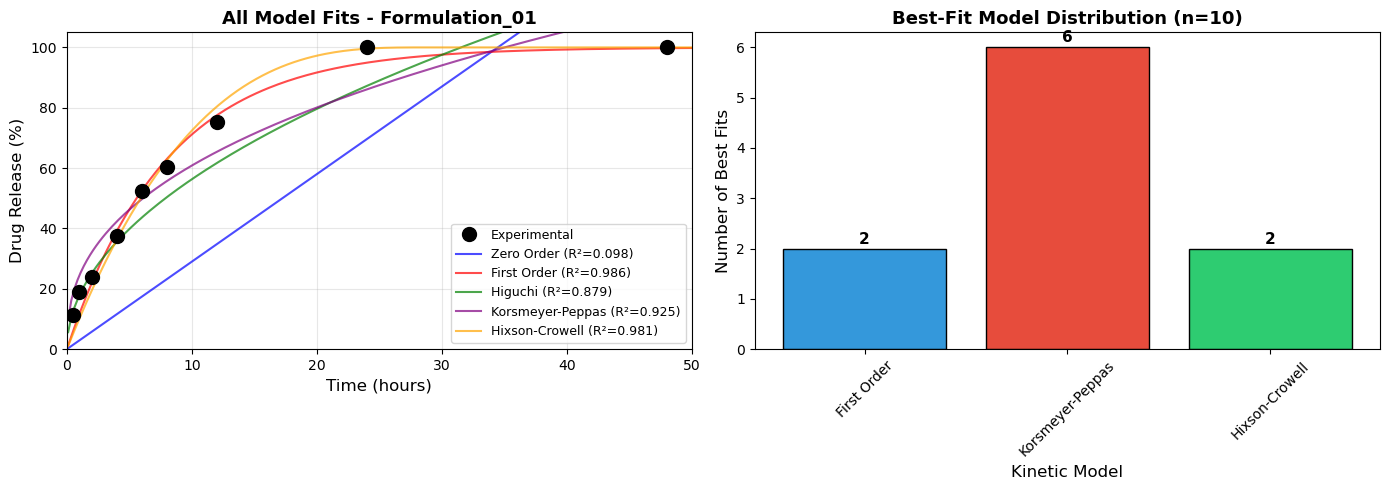


Figure saved as 'modular_codebase_demo.png'



In [2]:
"""
===============================================================================
MODULAR CODEBASE FOR DRUG RELEASE ANALYSIS
===============================================================================
Author: [Christopher Ezike]
Project: Pharmaceutical Research - Lamar University ChemE Dept
Date: July 2023

My code was getting really messy... everything was in one giant file
Senior grad student said "you need to make it modular"
I didn't know what that meant at first but now I do!

This file contains reusable functions for:
1. Curve fitting (multiple kinetic models)
2. Error quantification (R², RMSE, AIC, etc.)  
3. Batch processing of experimental datasets

Before: Copy-pasting the same code for every experiment
After: Call one function and it does everything!
===============================================================================
"""

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PART 1: KINETIC MODELS
# ============================================================================
# I put all the models in one place so I don't have to rewrite them

"""
My first version was like this (don't do this!):

def fit_formulation_1():
    # 50 lines of code
    
def fit_formulation_2():
    # same 50 lines copy-pasted
    
def fit_formulation_3():
    # same 50 lines copy-pasted AGAIN
    
# This was a nightmare to maintain!
"""

# Better approach: define models as separate functions that can be reused

def zero_order(t, k):
    """
    Zero-order kinetics: constant release rate
    Q = k * t
    Good for: Osmotic systems, some transdermal patches
    """
    return k * t

def first_order(t, k):
    """
    First-order kinetics: rate depends on remaining drug
    Q = Q_max * (1 - exp(-k*t))
    Good for: Water-soluble drugs in porous matrices
    """
    return 100 * (1 - np.exp(-k * t))

def higuchi(t, k):
    """
    Higuchi model: diffusion from a planar matrix
    Q = k * sqrt(t)
    Good for: Drug release from thin films, planar systems
    """
    return k * np.sqrt(t)

def korsmeyer_peppas(t, k, n):
    """
    Korsmeyer-Peppas: power law for polymeric systems
    Q = k * t^n
    
    The 'n' value tells us the release mechanism:
    - n < 0.45: Fickian diffusion
    - 0.45 < n < 0.89: Anomalous transport  
    - n > 0.89: Case II (relaxation-controlled)
    
    This is my favorite model because it's so informative!
    """
    return k * (t ** n)

def hixson_crowell(t, k, Q0=100):
    """
    Hixson-Crowell: accounts for changing surface area
    Q = Q0 * (1 - (1 - k*t/Q0^(1/3))^3)
    Good for: Dissolving tablets, particles
    
    I had to look this one up - it was hard to implement
    """
    term = 1 - k * t / (Q0 ** (1/3))
    term = np.maximum(term, 0)  # avoid negative numbers
    return Q0 * (1 - term ** 3)

# Dictionary of all models (makes it easy to loop through them)
MODELS = {
    'Zero Order': {'func': zero_order, 'p0': [2], 'params': ['k']},
    'First Order': {'func': first_order, 'p0': [0.1], 'params': ['k']},
    'Higuchi': {'func': higuchi, 'p0': [15], 'params': ['k']},
    'Korsmeyer-Peppas': {'func': korsmeyer_peppas, 'p0': [20, 0.5], 'params': ['k', 'n']},
    'Hixson-Crowell': {'func': hixson_crowell, 'p0': [1], 'params': ['k']}
}


# ============================================================================
# PART 2: ERROR QUANTIFICATION FUNCTIONS
# ============================================================================
# Dr. Martinez said R² isn't always enough - need multiple metrics

def calc_r_squared(observed, predicted):
    """
    Coefficient of determination (R²)
    
    R² = 1 - SS_res / SS_tot
    
    Range: -∞ to 1 (higher is better)
    R² > 0.9 is usually considered good for release data
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    
    if ss_tot == 0:
        return 0
    
    return 1 - (ss_res / ss_tot)


def calc_adjusted_r_squared(observed, predicted, n_params):
    """
    Adjusted R² - penalizes models with more parameters
    
    This is fairer when comparing models with different numbers of parameters
    I didn't know about this until Week 3!
    """
    n = len(observed)
    r2 = calc_r_squared(observed, predicted)
    
    if n - n_params - 1 <= 0:
        return r2
    
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_params - 1)
    return adj_r2


def calc_rmse(observed, predicted):
    """
    Root Mean Square Error
    
    RMSE = sqrt(mean((obs - pred)²))
    
    In same units as the data (% for drug release)
    Lower is better
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    return np.sqrt(np.mean((observed - predicted) ** 2))


def calc_mae(observed, predicted):
    """
    Mean Absolute Error
    
    Less sensitive to outliers than RMSE
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    return np.mean(np.abs(observed - predicted))


def calc_aic(observed, predicted, n_params):
    """
    Akaike Information Criterion
    
    AIC = n * ln(SS_res/n) + 2k
    
    Lower is better. Balances goodness of fit with model complexity.
    Dr. Martinez said journals like when you report this!
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    n = len(observed)
    
    ss_res = np.sum((observed - predicted) ** 2)
    
    if ss_res <= 0:
        return np.inf
    
    aic = n * np.log(ss_res / n) + 2 * n_params
    return aic


def calc_all_metrics(observed, predicted, n_params):
    """
    Calculate ALL error metrics at once
    
    Returns a dictionary with everything
    This function saves me so much time!
    """
    return {
        'R2': calc_r_squared(observed, predicted),
        'Adj_R2': calc_adjusted_r_squared(observed, predicted, n_params),
        'RMSE': calc_rmse(observed, predicted),
        'MAE': calc_mae(observed, predicted),
        'AIC': calc_aic(observed, predicted, n_params)
    }


# ============================================================================
# PART 3: CURVE FITTING FUNCTIONS
# ============================================================================

def fit_single_model(time, release, model_name):
    """
    Fit a single kinetic model to data
    
    Parameters:
    -----------
    time : array - time points
    release : array - release percentages
    model_name : str - name of model (must be in MODELS dict)
    
    Returns:
    --------
    dict with fitted parameters, predictions, and metrics
    
    I used to write this code over and over... now it's just one function!
    """
    if model_name not in MODELS:
        raise ValueError(f"Unknown model: {model_name}. Choose from {list(MODELS.keys())}")
    
    model_info = MODELS[model_name]
    func = model_info['func']
    p0 = model_info['p0']
    param_names = model_info['params']
    
    try:
        # Fit the model
        popt, pcov = curve_fit(func, time, release, p0=p0, maxfev=10000)
        
        # Get predictions
        predicted = func(time, *popt)
        
        # Calculate metrics
        metrics = calc_all_metrics(release, predicted, len(popt))
        
        # Package results
        params = {name: val for name, val in zip(param_names, popt)}
        
        return {
            'success': True,
            'model': model_name,
            'parameters': params,
            'predicted': predicted,
            'metrics': metrics
        }
        
    except Exception as e:
        return {
            'success': False,
            'model': model_name,
            'error': str(e)
        }


def fit_all_models(time, release):
    """
    Fit ALL kinetic models and compare them
    
    This is the function I use most - it does everything!
    """
    results = {}
    
    for model_name in MODELS.keys():
        result = fit_single_model(time, release, model_name)
        results[model_name] = result
    
    # Find best model by R²
    best_r2 = -np.inf
    best_model = None
    
    for name, result in results.items():
        if result['success'] and result['metrics']['R2'] > best_r2:
            best_r2 = result['metrics']['R2']
            best_model = name
    
    return {
        'all_fits': results,
        'best_model': best_model,
        'best_r2': best_r2
    }


# ============================================================================
# PART 4: BATCH PROCESSING
# ============================================================================
# This is where the modular approach REALLY pays off

def process_batch(datasets, time_column='time', release_column='release'):
    """
    Process multiple experimental datasets at once
    
    Parameters:
    -----------
    datasets : dict - {name: {'time': [...], 'release': [...]}, ...}
    
    Returns:
    --------
    Summary of all fits + recommendations
    
    Before: processing 15 formulations took me 2 hours
    After: takes about 30 seconds!
    """
    print("="*70)
    print("BATCH PROCESSING PHARMACEUTICAL RELEASE DATA")
    print("="*70)
    print(f"\nProcessing {len(datasets)} datasets...")
    
    all_results = {}
    
    for name, data in datasets.items():
        time = np.array(data['time'])
        release = np.array(data['release'])
        
        # Remove zero time point if present (causes issues with some models)
        mask = time > 0
        time = time[mask]
        release = release[mask]
        
        # Fit all models
        result = fit_all_models(time, release)
        all_results[name] = result
        
        # Print progress
        best = result['best_model']
        r2 = result['best_r2']
        print(f"  {name}: Best fit = {best} (R² = {r2:.4f})")
    
    return all_results


def generate_batch_report(batch_results):
    """
    Generate a summary report from batch processing
    
    I made this function because Dr. Martinez kept asking for summaries
    """
    print("\n" + "="*70)
    print("BATCH PROCESSING SUMMARY REPORT")
    print("="*70)
    
    # Count best models
    model_counts = {}
    r2_values = []
    
    for name, result in batch_results.items():
        best = result['best_model']
        r2 = result['best_r2']
        
        model_counts[best] = model_counts.get(best, 0) + 1
        r2_values.append(r2)
    
    print(f"\nTotal datasets analyzed: {len(batch_results)}")
    print(f"\nBest-fit model distribution:")
    for model, count in sorted(model_counts.items(), key=lambda x: -x[1]):
        pct = count / len(batch_results) * 100
        print(f"  {model}: {count} datasets ({pct:.1f}%)")
    
    print(f"\nR² Statistics:")
    print(f"  Mean:   {np.mean(r2_values):.4f}")
    print(f"  Std:    {np.std(r2_values):.4f}")
    print(f"  Min:    {np.min(r2_values):.4f}")
    print(f"  Max:    {np.max(r2_values):.4f}")
    
    # Identify any poor fits
    poor_fits = [name for name, result in batch_results.items() 
                 if result['best_r2'] < 0.90]
    
    if poor_fits:
        print(f"\n⚠️ Warning: {len(poor_fits)} dataset(s) with R² < 0.90:")
        for name in poor_fits:
            print(f"    - {name} (R² = {batch_results[name]['best_r2']:.4f})")
    else:
        print(f"\n✓ All datasets have R² ≥ 0.90")
    
    return {
        'model_counts': model_counts,
        'r2_mean': np.mean(r2_values),
        'r2_std': np.std(r2_values),
        'poor_fits': poor_fits
    }


# ============================================================================
# DEMONSTRATION / TESTING
# ============================================================================

if __name__ == "__main__":
    # Generate some test data (in real life this would be loaded from files)
    print("\n" + "="*70)
    print("TESTING THE MODULAR CODEBASE")
    print("="*70)
    
    np.random.seed(42)
    
    # Create 10 fake formulation datasets
    test_datasets = {}
    
    time_points = np.array([0.5, 1, 2, 4, 6, 8, 12, 24, 48])
    
    for i in range(1, 11):
        # Generate data with Korsmeyer-Peppas + noise
        k = np.random.uniform(12, 22)
        n = np.random.uniform(0.35, 0.65)
        release = k * (time_points ** n) + np.random.normal(0, 2, len(time_points))
        release = np.clip(release, 0, 100)
        
        test_datasets[f'Formulation_{i:02d}'] = {
            'time': time_points,
            'release': release
        }
    
    # Run batch processing
    results = process_batch(test_datasets)
    
    # Generate report
    report = generate_batch_report(results)
    
    # Visualize one example
    print("\n" + "="*70)
    print("EXAMPLE VISUALIZATION: Formulation_01")
    print("="*70)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: All model fits for one formulation
    ax1 = axes[0]
    
    example_data = test_datasets['Formulation_01']
    time = np.array(example_data['time'])
    release = np.array(example_data['release'])
    
    ax1.plot(time, release, 'ko', markersize=10, label='Experimental', zorder=5)
    
    t_smooth = np.linspace(0.1, 50, 200)
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for (model_name, model_info), color in zip(MODELS.items(), colors):
        fit_result = results['Formulation_01']['all_fits'][model_name]
        if fit_result['success']:
            params = list(fit_result['parameters'].values())
            y_smooth = model_info['func'](t_smooth, *params)
            r2 = fit_result['metrics']['R2']
            ax1.plot(t_smooth, y_smooth, '-', color=color, linewidth=1.5,
                    label=f"{model_name} (R²={r2:.3f})", alpha=0.7)
    
    ax1.set_xlabel('Time (hours)', fontsize=12)
    ax1.set_ylabel('Drug Release (%)', fontsize=12)
    ax1.set_title('All Model Fits - Formulation_01', fontsize=13, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 50)
    ax1.set_ylim(0, 105)
    
    # Plot 2: Best model distribution across all formulations
    ax2 = axes[1]
    
    models = list(report['model_counts'].keys())
    counts = list(report['model_counts'].values())
    
    bars = ax2.bar(models, counts, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12'][:len(models)],
                   edgecolor='black')
    ax2.set_xlabel('Kinetic Model', fontsize=12)
    ax2.set_ylabel('Number of Best Fits', fontsize=12)
    ax2.set_title('Best-Fit Model Distribution (n=10)', fontsize=13, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add count labels
    for bar, count in zip(bars, counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('modular_codebase_demo.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nFigure saved as 'modular_codebase_demo.png'")
    print("\n" + "="*70)

